## Introduction to NLP with TensorFlow
We'll use kaggle disaster tweet datasets for this exercise: https://www.kaggle.com/competitions/nlp-getting-started
And we'll classify these tweets into disaster v/s non disaster tweets

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b9543680-5885-9b7f-ac92-e74fe3fb144c)


In [2]:
from helper_functions import unzip_data, walk_through_dir, create_tensorboard_callback, plot_loss_curves

## Get the data

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2022-08-15 01:49:58--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 172.217.219.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2022-08-15 01:49:58 (159 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [4]:
unzip_data("/content/nlp_getting_started.zip")

In [5]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Visualize data

In [6]:
train_df["text"].iloc[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [7]:
train_df_shuffled = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
train_df_shuffled.head()

,id,keyword,location,text,target
0,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
1,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
2,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
3,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
4,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [9]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [11]:
len(train_df), len(test_df)

(7613, 3263)

In [12]:
# Visuaize Random Data

In [13]:
import random

random_index = random.randint(0, len(train_df)-5)
i = 0
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  target_str = 'not a real disaster'
  if target > 0:
    target_str = 'real_disaster'
  
  print(f"#{i+1} {target_str}({target})")
  print(f"\n{text}\n")
  print(f"------------")
  i += 1

#1 not a real disaster(0)

Smoke with me baby and lay with me baby and laugh with me baby I just want the simple things

------------
#2 not a real disaster(0)

Currently want to drive my car off a cliff and fall to my death.

------------
#3 not a real disaster(0)

'It hasn't collapsed because the Greek people are still being played for as fools by Tsipras he costÛ_' ÛÓ WallyBaiter http://t.co/gbRNuLp3fH

------------
#4 real_disaster(1)

UPDATE 1-Russian 'food crematoria' provoke outrage amid crisis famine memories: * Russian society still recal... http://t.co/J2erZbMjQD

------------
#5 not a real disaster(0)

General News Û¢åÊ'Demolition of houses on waterways begins at Achimota Mile 7 ' via @233liveOnline. Full story at http://t.co/iO7kUUg1uq

------------


### Create train test splits

In [14]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                              train_df_shuffled["target"].to_numpy(),
                                                                              test_size = 0.1,
                                                                              random_state=42)

In [15]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [16]:
train_sentences[:5], train_labels[:5]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
       dtype=object), array([0, 0, 1, 0, 0]))

## Convert text into numbers
Using 
1. Tokenization -> To integers or one-hot 
2. Embeddings -> Size of embedding can be defined and learned as a layer in NN

### Tokenize using TextVectorizaion layer in TensorFlow

In [17]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [18]:
text_vectorizer = TextVectorization(max_tokens = 10000, ## This is vocab size. If set to some number say 100 then words with lower freq than first 100 words will be replaces with <UNK>
                                    standardize = 'lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None, ## Can specify ngram length, If not set, will take 1
                                    output_mode='int', # can be 'int', one-hot etc
                                    output_sequence_length=None, # If set to None, will automatically set the max_length of all sequences. Can specify limit also
                                    pad_to_max_tokens=True) # Whether to pad to match the output_sequence_length)

In [19]:
len(train_sentences[0].split())

7

In [20]:
# Average length of the sentences in train data
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [21]:
max_vocab_size = 10000
max_length = 15

In [22]:
text_vectorizer = TextVectorization(max_tokens = max_vocab_size,
                                    output_sequence_length=max_length,
                                    output_mode = 'int'
                                    )

### Adapt the text_vectorizer to test_sentence

In [23]:
text_vectorizer.adapt(val_sentences)

In [24]:
sample_sentences = ["There is a flood in Bengaluru",
                    "I love Tensorflow"]
text_vectorizer(sample_sentences)

<tf.Tensor: shape=(2, 15), dtype=int64, numpy=
array([[ 72,  10,   3, 145,   4,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  8, 102,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [25]:
vocab = text_vectorizer.get_vocabulary()
vocab[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'for']

In [26]:
random_sentence = random.choice(train_sentences)
print(f"""
Sentence Before: \n
{random_sentence} \n
After Tokenization: \n
{text_vectorizer([random_sentence])}
""")


Sentence Before: 

What's happening? A destruction indeed http://t.co/tUX0YPwZuR 

After Tokenization: 

[[ 217    1    3  470 1027    1    0    0    0    0    0    0    0    0
     0]]



## Converting tokens to embeddings (Embedding Layer)
The parameters we are most interested in are:
1. `input_dim`: Size of vocabulary
2. `output_dim`: The length of embedding that we want to learning (embedding vector size)
3. `input_length`: Length of input that the Embedding layer is expecting (Size of tokenized sentence)

In [27]:
embedding = tf.keras.layers.Embedding(input_dim = max_vocab_size,
                                      output_dim = 128,
                                      input_length = max_length)

In [28]:
random_sentence = random.choice(train_sentences)
print(f"""
Sentence Before: \n
{random_sentence} \n
After Tokenization: \n
{text_vectorizer([random_sentence])}\n
After embedding: \n
{embedding(text_vectorizer([random_sentence]))}\n
Shape After embedding: {embedding(text_vectorizer([random_sentence])).shape}
""")


Sentence Before: 

EUROCRISIS Guardian Greece's tax revenues collapse as debt crisis continues: As talks continue over proposed âÂ... http://t.co/bBm9sR1wOw 

After Tokenization: 

[[   1 3393    1  803    1  121   33 3788 3854 3899   33    1 3901   86
     1]]

After embedding: 

[[[-0.04807223 -0.03561002 -0.04928724 ... -0.02789048 -0.01194455
   -0.00150535]
  [ 0.03130168  0.00190645  0.01185944 ... -0.01751944  0.04779072
    0.04950236]
  [-0.04807223 -0.03561002 -0.04928724 ... -0.02789048 -0.01194455
   -0.00150535]
  ...
  [-0.04221169  0.03663366  0.00427345 ... -0.03395971  0.02158852
   -0.04304406]
  [ 0.02599828  0.04261773  0.01069325 ...  0.04835011  0.01023247
    0.02366519]
  [-0.04807223 -0.03561002 -0.04928724 ... -0.02789048 -0.01194455
   -0.00150535]]]

Shape After embedding: (1, 15, 128)



## Modeling experiments

1. Model 0: Naive Bayes (https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) -> Baseline
2. Model 1: FFNN
3. Model 2: LSTM
4. Model 3: GRU
5. Model 4: Bidirectional LSTM
7. Model 5: 1D CNN
7. Model 6: Pretrained from tensorflow hub
8. Model 7: Pretrained from tensorflow hub with 10% data


## Model 0: tf-idf Naive Bayes

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix

In [30]:
model_0 = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_0.fit(train_sentences, train_labels)

predictions = model_0.predict(val_sentences)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


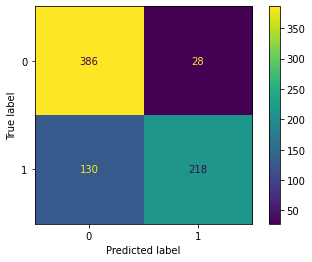

In [31]:
plot_confusion_matrix(model_0, val_sentences, val_labels)

In [32]:
accuracy_0 = accuracy_score(val_labels, predictions)
print(f"Accuracy of tf-idf Naive Bayes Model: {accuracy_0*100:.2f}%")

Accuracy of tf-idf Naive Bayes Model: 79.27%


In [33]:
## Define a function to calculate model results
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred) * 100
  precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  return {
      'accuracy': acc,
      'precision': precision,
      'recall': recall,
      'f_score': f_score 
  }

In [34]:
baseline_results = calculate_results(val_labels, predictions)
baseline_results

{'accuracy': 79.26509186351706,
 'f_score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 1: A simple Dense model

In [35]:
# Create tensorboard callback:
SAVE_DIR = "disaster_tweet_classification"

In [36]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string) # Data for one tweet is a string
x = text_vectorizer(inputs)
x = embedding(x)
#x = tf.keras.layers.Flatten()(x) 
x = tf.keras.layers.GlobalAveragePooling1D()(x) # Instead of Flattening, we can try with GlobalAVg 
                                                # This will make sure that we are getting avg of all
                                                # tokens for every embedding dimension
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-train

In [37]:
model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

history_1 = model_1.fit(
    x = train_sentences, y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "simple_dense_model")]
)

Saving TensorBoard log files to: disaster_tweet_classification/simple_dense_model/20220815-015003
Epoch 1/5
215/215 [==============================] - 5s 5ms/step - loss: 0.6197 - binary_accuracy: 0.6768 - val_loss: 0.5383 - val_binary_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4766 - binary_accuracy: 0.7949 - val_loss: 0.4700 - val_binary_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4097 - binary_accuracy: 0.8279 - val_loss: 0.4556 - val_binary_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3733 - binary_accuracy: 0.8394 - val_loss: 0.4569 - val_binary_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3474 - binary_accuracy: 0.8516 - val_loss: 0.4721 - val_binary_accuracy: 0.7874


In [38]:
results_1 = model_1.evaluate(val_sentences, val_labels)
results_1

24/24 [==============================] - 0s 3ms/step - loss: 0.4721 - binary_accuracy: 0.7874


[0.47206756472587585, 0.787401556968689]

In [39]:
predictions = model_1.predict(val_sentences)
dense_model_results = calculate_results(val_labels, tf.round(predictions))
dense_model_results

{'accuracy': 78.74015748031496,
 'f_score': 0.7850997256765829,
 'precision': 0.7903907506573856,
 'recall': 0.7874015748031497}

In [40]:
baseline_results

{'accuracy': 79.26509186351706,
 'f_score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

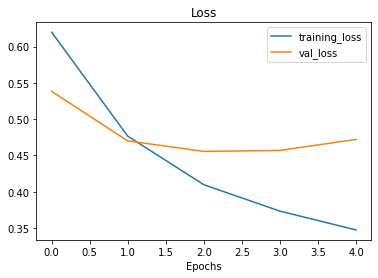

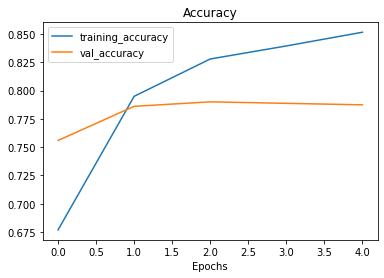

In [41]:
plot_loss_curves(history_1)

**The model is too much overfitting**. *And the model is not better than the baseline model*

### Visualize word embedding with TF's projector tool
**Projector tool: https://projector.tensorflow.org/**

In [42]:
vocab[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'for']

In [43]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-train

In [44]:
model_1.layers

In [45]:
embedding_weights = model_1.layers[2].weights
len(embedding_weights)

1

In [46]:
embedding_weights[0].shape ## for every token in the vocab these is a vector of 128 dims

TensorShape([10000, 128])

In [47]:
embedding_weights[0][:10, :] ## These are embeddings of first 10 words in the vocab

<tf.Tensor: shape=(10, 128), dtype=float32, numpy=
array([[ 0.07138572, -0.01185519, -0.0248578 , ..., -0.02611909,
         0.03053484,  0.02580749],
       [-0.03043846, -0.01855325, -0.03240226, ..., -0.04470971,
        -0.02538612,  0.01593359],
       [ 0.04391601,  0.05214456,  0.04515497, ..., -0.04017063,
        -0.06229727, -0.02267698],
       ...,
       [ 0.00706082,  0.08745136,  0.06232192, ..., -0.01369399,
        -0.05864647,  0.04389907],
       [ 0.10630005,  0.03987752,  0.08716022, ..., -0.12575234,
        -0.05309796,  0.0964968 ],
       [ 0.01171939,  0.01765108,  0.01877287, ..., -0.04970735,
         0.00221921,  0.0397637 ]], dtype=float32)>

In [48]:
# import io

# # Copied following code from: 
# # https://www.tensorflow.org/text/guide/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk

# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = embedding_weights[0][index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()

In [49]:
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## Model 2: LSTM

Note about LSTM (or SimpleRNN) Refer: https://www.tensorflow.org/guide/keras/rnn#outputs_and_states

By defalut and LSTM layer return one output per sequence, i.e. the final hidden state of the last time step. 
So if we use LSTM with default parameters then the input and output shape will be

`in_shape = (batch_size, seq_len (timestep), feature_size)`

`out_shape = (batch_size, n_units)` where n_units = # hidden units inside an LSTM cell

If we use LSTM layer with `return_sequence = True` then the LSTM will return hidden state for every time step. In this case input and output size will be

`in_shape = (batch_size, seq_len (timestep), feature_size)`

`out_shape = (batch_size, seq_len (timestep), n_units)` where n_units = hidden unit inside an LSTM cell. Refer: https://i.stack.imgur.com/dkXgO.jpg 

In [50]:
inputs = tf.keras.layers.Input(shape=(1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)

# When using RNNs one after the another make sure that the initial RNNs return_sequences is set to True.
# Otherwise it will squeeze the seq_len dimension and return a output of shape units.
# Since the LSTM expects inputs to be of shape <batch_size, seq_len, size> (or n_dim=3)
# If we don't set return_sequence = True then n_dim for output will be 2 and the next 
# LSTM will result in error
x = tf.keras.layers.LSTM(units = 64, return_sequences=True)(x)
print(x.shape)

# This LSTM layer will squeee the seq_len dim and will return a single output of size (units) for a seq
x = tf.keras.layers.LSTM(units = 64)(x)
print(x.shape)
x = tf.keras.layers.Dense(64)(x)
print(x.shape)

(None, 15, 128)
(None, 15, 64)
(None, 64)
(None, 64)


In [51]:
inputs = tf.keras.Input(shape=(1,), dtype = 'string')
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.LSTM(64)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs)
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________

In [52]:
model_2.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.BinaryAccuracy()] 
)

history_2 = model_2.fit(
    train_sentences, train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback("disaster_tweet_classification",
                                             "single_layer_lstm")]
)

Saving TensorBoard log files to: disaster_tweet_classification/single_layer_lstm/20220815-015016
Epoch 1/5
215/215 [==============================] - 9s 17ms/step - loss: 0.3535 - binary_accuracy: 0.8516 - val_loss: 0.4823 - val_binary_accuracy: 0.7940
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3172 - binary_accuracy: 0.8686 - val_loss: 0.5083 - val_binary_accuracy: 0.7966
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2983 - binary_accuracy: 0.8729 - val_loss: 0.5366 - val_binary_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2809 - binary_accuracy: 0.8832 - val_loss: 0.6217 - val_binary_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2588 - binary_accuracy: 0.8923 - val_loss: 0.6334 - val_binary_accuracy: 0.7822


In [53]:
predictions = model_2.predict(val_sentences)
results_2 = calculate_results(val_labels, tf.round(predictions))
results_2

{'accuracy': 78.21522309711287,
 'f_score': 0.7797935460636591,
 'precision': 0.7849731976577976,
 'recall': 0.7821522309711286}

In [54]:
baseline_results

{'accuracy': 79.26509186351706,
 'f_score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

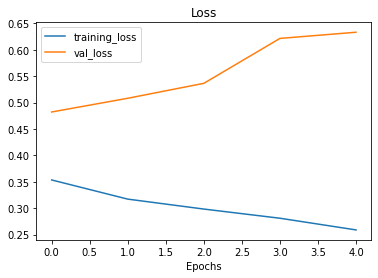

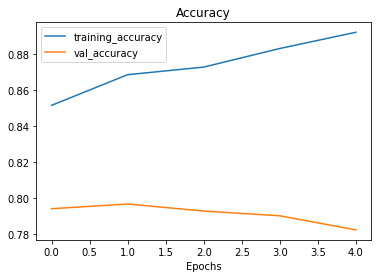

In [55]:
plot_loss_curves(history_2)

## Model 3: GRU

In [56]:
inputs = tf.keras.layers.Input(shape=(1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GRU(64)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.Model(inputs, outputs)
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________

In [57]:
model_3.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.BinaryAccuracy()] 
)

history_3 = model_3.fit(
    train_sentences, train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback("disaster_tweet_classification",
                                             "single_layer_gru")]
)

Saving TensorBoard log files to: disaster_tweet_classification/single_layer_gru/20220815-015037
Epoch 1/5
215/215 [==============================] - 4s 11ms/step - loss: 0.3202 - binary_accuracy: 0.8602 - val_loss: 0.5455 - val_binary_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2543 - binary_accuracy: 0.8987 - val_loss: 0.6673 - val_binary_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2220 - binary_accuracy: 0.9126 - val_loss: 0.7021 - val_binary_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1963 - binary_accuracy: 0.9206 - val_loss: 0.9057 - val_binary_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1717 - binary_accuracy: 0.9291 - val_loss: 0.9492 - val_binary_accuracy: 0.7861


In [58]:
predictions = model_3.predict(val_sentences)
results_3 = calculate_results(val_labels, tf.round(predictions))
results_3

{'accuracy': 78.60892388451444,
 'f_score': 0.7835741000287678,
 'precision': 0.7895616761419161,
 'recall': 0.7860892388451444}

In [59]:
baseline_results

{'accuracy': 79.26509186351706,
 'f_score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 4: Bidirectional LSTM

In [60]:
inputs = tf.keras.layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.Model(inputs, outputs)
model_4.summary()

model_4.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

history_4 = model_4.fit(
    train_sentences, train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR,
                                              "single_layer_bilstm")]
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-tra

In [61]:
predictions = model_4.predict(val_sentences)
results_4 = calculate_results(val_labels, tf.round(predictions))
results_4

{'accuracy': 77.69028871391076,
 'f_score': 0.7743498017353971,
 'precision': 0.7798819103655997,
 'recall': 0.7769028871391076}

## Model 5: Conv1D 

In [62]:
inputs = tf.keras.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
x = tf.keras.layers.Conv1D(64, 5, activation='relu', padding='valid')(x)
#print(x.shape)
#x = tf.keras.layers.MaxPooling1D()(x)
#print(x.shape)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
#print(x.shape)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#print(x.shape)

model_5 = tf.keras.Model(inputs, outputs)
model_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_5 (Dense)             (None, 1)                 65  

In [63]:
model_5.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

history_5 = model_5.fit(
    train_sentences, train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR,
                                             "simple_cnn_1d_model")]
)

Saving TensorBoard log files to: disaster_tweet_classification/simple_cnn_1d_model/20220815-015116
Epoch 1/5
215/215 [==============================] - 9s 6ms/step - loss: 0.2842 - binary_accuracy: 0.8797 - val_loss: 0.6783 - val_binary_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2358 - binary_accuracy: 0.9042 - val_loss: 0.7105 - val_binary_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1951 - binary_accuracy: 0.9272 - val_loss: 0.8275 - val_binary_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1620 - binary_accuracy: 0.9388 - val_loss: 0.9766 - val_binary_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1356 - binary_accuracy: 0.9499 - val_loss: 0.9795 - val_binary_accuracy: 0.7717


In [64]:
predictions = model_5.predict(val_sentences)
results_5 = calculate_results(val_labels, tf.round(predictions))
results_5

{'accuracy': 77.16535433070865,
 'f_score': 0.7705026760144871,
 'precision': 0.7717840407633899,
 'recall': 0.7716535433070866}

In [65]:
baseline_results

{'accuracy': 79.26509186351706,
 'f_score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 6: Tensorflow hub feature extractor model - Universal Sentence Encoder

In [66]:
import tensorflow_hub as hub

embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embeddings = embed(['I love NLP', 'I love Tensorflow'])

embeddings

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[ 0.04771782,  0.01360247, -0.04161041, ...,  0.04108613,
        -0.00541195, -0.07477576],
       [ 0.05399963, -0.06587097, -0.03254663, ...,  0.07745957,
        -0.03356914, -0.0742834 ]], dtype=float32)>

In [67]:
encoding_layer = hub.KerasLayer(handle = 'https://tfhub.dev/google/universal-sentence-encoder/4',
                                 input_shape = [], 
                                 dtype = tf.string)
encoding_layer

In [68]:
model_6 = tf.keras.Sequential(
    [
        encoding_layer,
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

model_6.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

history_6 = model_6.fit(
    train_sentences, train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR,
                                             "USE_TensorflowHub_Pretrained_Feature_extractor_model")]
)

Saving TensorBoard log files to: disaster_tweet_classification/USE_TensorflowHub_Pretrained_Feature_extractor_model/20220815-015148
Epoch 1/5
215/215 [==============================] - 5s 13ms/step - loss: 0.4821 - binary_accuracy: 0.7860 - val_loss: 0.4453 - val_binary_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4012 - binary_accuracy: 0.8269 - val_loss: 0.4183 - val_binary_accuracy: 0.8176
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3817 - binary_accuracy: 0.8340 - val_loss: 0.4221 - val_binary_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3623 - binary_accuracy: 0.8448 - val_loss: 0.4186 - val_binary_accuracy: 0.8241
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3410 - binary_accuracy: 0.8581 - val_loss: 0.4225 - val_binary_accuracy: 0.8176


In [69]:
predictions = model_6.predict(val_sentences)
results_6 = calculate_results(val_labels, tf.round(predictions))
results_6, baseline_results

({'accuracy': 81.75853018372703,
  'f_score': 0.8167061279584483,
  'precision': 0.8182399886244468,
  'recall': 0.8175853018372703},
 {'accuracy': 79.26509186351706,
  'f_score': 0.7862189758049549,
  'precision': 0.8111390004213173,
  'recall': 0.7926509186351706})

## Model 7: Pretrained model on 10% data

In [70]:
train_df_shuffled.head()

,id,keyword,location,text,target
0,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
1,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
2,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
3,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
4,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [71]:
train_df_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_df_10_percent["text"].to_list()
train_labels_10_percent = train_df_10_percent["target"].to_list()

print(len(train_sentences_10_percent), len(train_labels_10_percent))

761 761


In [72]:
train_df_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [73]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [74]:
model_7 = tf.keras.models.clone_model(model_6)
model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,834,881
Trainable params: 37,057
Non-trainable params: 256,797,824
_________________________________________________________________


In [75]:
model_7.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

history_7 = model_7.fit(
    train_sentences_10_percent, train_labels_10_percent,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR,
                                             "USE_TensorflowHub_Pretrained_Feature_extractor_model_10_percent_data")]
)

Saving TensorBoard log files to: disaster_tweet_classification/USE_TensorflowHub_Pretrained_Feature_extractor_model_10_percent_data/20220815-015207
Epoch 1/5
24/24 [==============================] - 4s 38ms/step - loss: 0.6778 - binary_accuracy: 0.6820 - val_loss: 0.6451 - val_binary_accuracy: 0.8018
Epoch 2/5
24/24 [==============================] - 1s 25ms/step - loss: 0.5963 - binary_accuracy: 0.7950 - val_loss: 0.5196 - val_binary_accuracy: 0.8110
Epoch 3/5
24/24 [==============================] - 0s 20ms/step - loss: 0.4720 - binary_accuracy: 0.8081 - val_loss: 0.4119 - val_binary_accuracy: 0.8268
Epoch 4/5
24/24 [==============================] - 1s 24ms/step - loss: 0.3972 - binary_accuracy: 0.8239 - val_loss: 0.3553 - val_binary_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 1s 24ms/step - loss: 0.3496 - binary_accuracy: 0.8541 - val_loss: 0.3157 - val_binary_accuracy: 0.8609


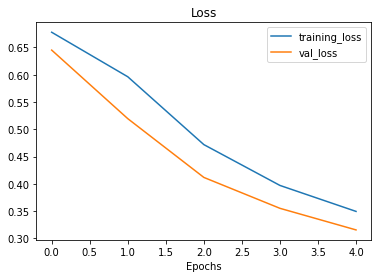

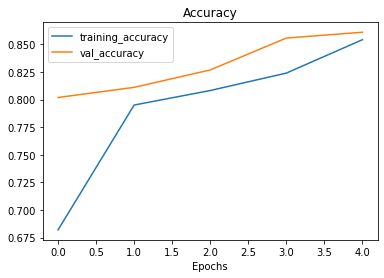

In [76]:
plot_loss_curves(history_7)

In [77]:
predictions = model_7.predict(val_sentences)
results = calculate_results(val_labels, tf.round(predictions))
results

{'accuracy': 86.08923884514435,
 'f_score': 0.8610041988930985,
 'precision': 0.8613062751115816,
 'recall': 0.8608923884514436}

## Why is the model with 10% data is performing better that the model with full data??
We created train, val sentences using train_df_shuffled by train_test_split. But then we created 10% data using train_df_shuffled, so some of the sentences of val_sentences might be in train_10_percent data. so this is a data leakage problem. Hence we got higher accuracy with 10% data

❌ train_df_shuffled -> train_sentences, val_sentences -> train_sentences_10_percent

✅ train_sentences -> train_sentences_10_percent

In [78]:
len_10_percent = int(0.1*len(train_sentences))
train_10_percent_sentences = train_sentences[:len_10_percent]
train_10_percent_labels = train_labels[:len_10_percent]

len(train_10_percent_sentences), len(train_10_percent_labels)

(685, 685)

In [79]:
model_8 = tf.keras.models.clone_model(model_7)
model_8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,834,881
Trainable params: 37,057
Non-trainable params: 256,797,824
_________________________________________________________________


In [80]:
model_8.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)
history_8 = model_8.fit(
    train_10_percent_sentences, 
    train_10_percent_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR,
                                             "USE_TensorflowHub_Pretrained_Feature_extractor_model_10_percent_data_correct_splits")]
)

Saving TensorBoard log files to: disaster_tweet_classification/USE_TensorflowHub_Pretrained_Feature_extractor_model_10_percent_data_correct_splits/20220815-020636
Epoch 1/5
22/22 [==============================] - 4s 44ms/step - loss: 0.6754 - binary_accuracy: 0.6818 - val_loss: 0.6545 - val_binary_accuracy: 0.6732
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5925 - binary_accuracy: 0.7898 - val_loss: 0.5553 - val_binary_accuracy: 0.7822
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4674 - binary_accuracy: 0.8190 - val_loss: 0.4812 - val_binary_accuracy: 0.7822
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.3790 - binary_accuracy: 0.8438 - val_loss: 0.4837 - val_binary_accuracy: 0.7690
Epoch 5/5
22/22 [==============================] - 1s 25ms/step - loss: 0.3350 - binary_accuracy: 0.8613 - val_loss: 0.5092 - val_binary_accuracy: 0.7717


In [81]:
predictions = model_8.predict(val_sentences)
results_8 = calculate_results(val_labels, tf.round(predictions))
results_8

{'accuracy': 77.16535433070865,
 'f_score': 0.7684419786377588,
 'precision': 0.7758922411539364,
 'recall': 0.7716535433070866}

In [82]:
baseline_results

{'accuracy': 79.26509186351706,
 'f_score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Compare model results

In [91]:
all_models_results = pd.DataFrame({"0_baseline": baseline_results,
                                   "1_simple_dense": dense_model_results,
                                   "2_lstm": results_2,
                                   "3_gru": results_3,
                                   "4_bilstm": results_4,
                                   "5_conv1d": results_5,
                                   "6_tfhub_extractor": results_6,
                                   "7_tfhub_extractor_10_per": results,
                                   "8_tfhub_extractor_10_per_corrected": results_8})
all_models_results = all_models_results.transpose()

In [92]:
all_models_results["accuracy"] = all_models_results["accuracy"] / 100.
all_models_results

,accuracy,precision,recall,f_score
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.787402,0.790391,0.787402,0.785100
2_lstm,0.782152,0.784973,0.782152,0.779794
3_gru,0.786089,0.789562,0.786089,0.783574
4_bilstm,0.776903,0.779882,0.776903,0.774350
5_conv1d,0.771654,0.771784,0.771654,0.770503
6_tfhub_extractor,0.817585,0.818240,0.817585,0.816706
7_tfhub_extractor_10_per,0.860892,0.861306,0.860892,0.861004
8_tfhub_extractor_10_per_corrected,0.771654,0.775892,0.771654,0.768442


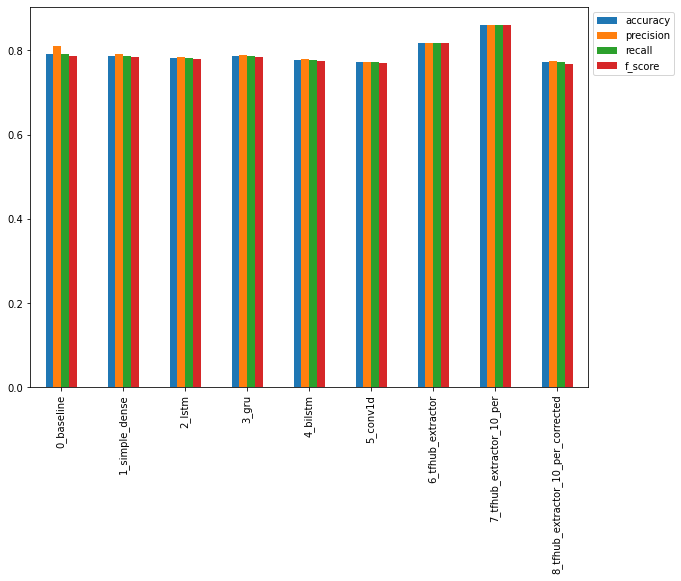

In [97]:
all_models_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

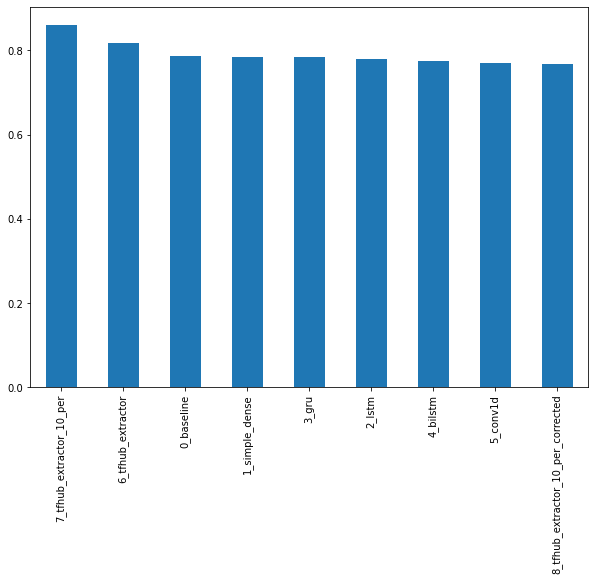

In [100]:
all_models_results.sort_values("f_score", ascending=False)["f_score"].plot(kind='bar', figsize=(10, 7));

## Tensorboard dev upload

In [103]:
!tensorboard dev upload --logdir ./disaster_tweet_classification \
  --name "Disasted Tweet Classification" \
  --description "Comparing different NLP algorithms performance on Kaggle Tweet Classification" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./disaster_tweet_classification

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=mfPOb2ByvSqRN6bXI6upE4DGBR8JLq&prompt=consent&a

## Save and load model

### HDF5 format

In [104]:

model_6.save("model_6.h5")

In [110]:
loaded_model = tf.keras.models.load_model("model_6.h5",
                                          custom_objects={"KerasLayer": hub.KerasLayer})
loaded_model.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 18ms/step - loss: 0.4225 - binary_accuracy: 0.8176


[0.42246511578559875, 0.817585289478302]

In [109]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,834,881
Trainable params: 37,057
Non-trainable params: 256,797,824
_________________________________________________________________


In [107]:
model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,834,881
Trainable params: 37,057
Non-trainable params: 256,797,824
_________________________________________________________________


### SavedModel format

In [111]:
model_6.save("model_6_SavedModel")

In [112]:
loaded_model_SavedModel = tf.keras.models.load_model("model_6_SavedModel")
loaded_model_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 19ms/step - loss: 0.4225 - binary_accuracy: 0.8176


[0.42246508598327637, 0.817585289478302]

## Most wrong predictions

## Speed / score tradeoff

In [113]:
baseline_results

{'accuracy': 79.26509186351706,
 'f_score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [114]:
results_6

{'accuracy': 81.75853018372703,
 'f_score': 0.8167061279584483,
 'precision': 0.8182399886244468,
 'recall': 0.8175853018372703}

In [117]:
import time
def pred_timer(model, samples):
  """
  Calculates time taken for a prediction
  """
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_pred = total_time / len(samples)
  return total_time, time_per_pred

In [118]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.416365706999386, 0.0005464116889755722)

In [120]:
baseline_model_pred_time, baseline_model_pred_time_per_pred = pred_timer(model_0, val_sentences)
baseline_model_pred_time, baseline_model_pred_time_per_pred

(0.04774870900018868, 6.266234776927649e-05)

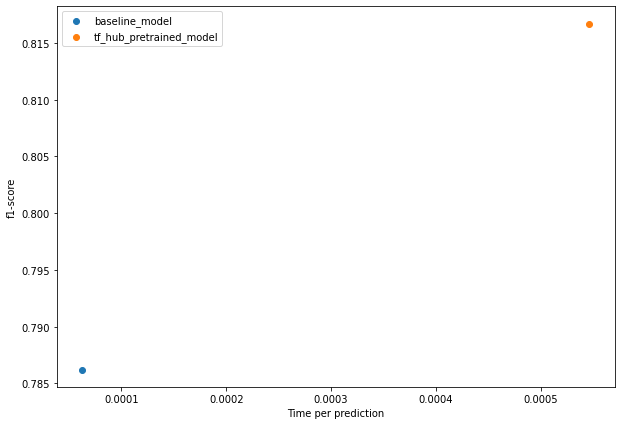

In [121]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(baseline_model_pred_time_per_pred, baseline_results["f_score"], label="baseline_model")
plt.scatter(model_6_time_per_pred, results_6["f_score"], label="tf_hub_pretrained_model")
plt.legend()
plt.xlabel("Time per prediction")
plt.ylabel("f1-score")
plt.show();